# 0.0: Welcome to `netrd`!
## This notebook will detail the main tools and functionality of `netrd`

Created by Brennan Klein: May 22nd, 2019. For questions, comments, concerns, and more, reach out at 

    brennanjamesklein at gmail dot com

Note: Currently, the output of each cell is included as an inserted .png from the "output_figures/" folder for readability. When using this document, you will probably want to remove those markdown cells to create graphics of your own.

### Other resources:
- __[View this notebook on NBviewer](https://nbviewer.jupyter.org/github/jkbren/netrd/blob/master/notebooks/netrd_introduction.ipynb)__
- __[Visit the github](https://github.com/netsiphd/netrd)__
- __[Visit the ReadTheDocs](https://netrd.readthedocs.io/en/latest/)__
- __[Visit the netrdExplorer website](https://netrdexplorer.herokuapp.com/)__

_________________

### Introduction:

**"Comparing methods for reconstructing networks from time series data by comparing methods for measuring network similarity"**

Across many disciplines, we analyze networks that have been reconstructed or inferred from time series data (e.g., changes in brain activity in neuroscience, shifting stock prices in economics, population dynamics in ecology). These networks can be reconstructed using a variety of techniques, but because different algorithms can output different networks, practitioners are often uncertain about whether their approach is suitable for describing the system in question. Similar to other tools in network science, it appears that no single technique is universally optimal for inferring network structure from time series data. The absence of a "best" technique is likely due to several factors, from the quality or amount of time series data collected, to the nature of the system or dynamics being modeled, to the types of interactions between entities in the system (causal, correlational, weighted, etc.). 

In this work, we review dozens of network reconstruction techniques in order to characterize the extent to which different techniques will output networks that are similar to one another. The goal of this review is *not* to provide estimates of the "best" network reconstruction technique but rather to identify approaches that are more likely to infer similar network structures given the same time series data. In doing so, we also systematically compare a number of techniques for measuring network similarity or (also known as graph distance). By also releasing the methods implemented in this work as a software package, **`netrd`**, we hope this research will spur new insights about possible latent similarities between the mathematical, algorithmic, or theoretical aspects of different network reconstruction techniques and of different network similarity measures.

_________________

In [1]:
import netrd
import networkx as nx
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import gridspec

from netrd.utilities import standardize
%matplotlib inline

In [2]:
folder_to_savefigs_to = ""
# folder_to_savefigs_to = "output_figures"

_________________

# 0.1: Plotting and simulation functions (run these and continue below)

In [3]:
def plot_groundtruth_timeseries_adjmat(G0, TS, 
                                       dyna_name='SherringtonKirkpatrickIsing', 
                                       colmap=plt.cm.Greys, save=True):
    ns = 100
    nc = 'w'
    ec = '#333333'
    oc = '#e4c600'
    nc_o = '#333333'

    plt.rc('axes', linewidth=2)
    pos = nx.kamada_kawai_layout(G0)

    fig, ax = plt.subplots(1,1,figsize=(18,4))
    gs      = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1]) 

    ax0 = plt.subplot(gs[0])
    nx.draw_networkx_nodes(G0, pos, node_size=ns, node_color=nc, 
                           linewidths=2.5, edgecolors=nc_o, ax=ax0)
    nx.draw_networkx_edges(G0, pos, width=1.75,   edge_color=ec, 
                           alpha=0.5, ax=ax0)
    ax0.set_title("Ground truth network", size=14)
    ax0.set_axis_off()

    ax1 = plt.subplot(gs[1])
    ax1.imshow(TS,cmap=plt.cm.Greys,aspect='auto')
    ax1.set_yticks([])
    ax1.set_xlabel("Time", size=14)
    ax1.set_ylabel("Node ID", size=14)
    ax1.set_title("%s dynamics"%dyna_name, size=14)

    ax2 = plt.subplot(gs[2])
    W0 = nx.to_numpy_array(G0)
    ax2.pcolor(W0, cmap=plt.cm.Greys, edgecolors='w', linewidth=0.2)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.invert_yaxis()
    ax2.set_title('Ground truth adjacency matrix', size=14)

    if save==True:
        plt.savefig(folder_to_savefigs_to+"ExampleGroundTruth_%s.png"%dyna_name, 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"ExampleGroundTruth_%s.pdf"%dyna_name, 
                    dpi=425, bbox_inches='tight')

    plt.show()
    plt.rc('axes', linewidth=1)
    
def plot_adjmat_timeseries_recon(G0, TS, recons, 
                                 recon_name='FreeEnergyMinimization', 
                                 colmap=plt.cm.Greys,
                                 save=True):
    plt.rc('axes', linewidth=2)

    W0 = nx.to_numpy_array(G0)
    k_avg = np.mean(list(dict(G0.degree()).values()))
    ### Reconstruct the network and turn it into an adjacency matrix ###
    R1 = recons[recon_name]
    Gr = R1.fit(TS, threshold_type='degree', avg_k=k_avg)
    Wr = nx.to_numpy_array(Gr)
    
    # plotting
    fig, ax = plt.subplots(1,1,figsize=(18,4))
    gs      = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1]) 

    ax0 = plt.subplot(gs[0])
    ax0.pcolor(W0, cmap=colmap, edgecolors='w', linewidth=0.5)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.invert_yaxis()
    ax0.set_title('Ground truth adjacency matrix', size=14)

    ax1 = plt.subplot(gs[1])
    ax1.imshow(TS, cmap=colmap, aspect='auto')
    ax1.set_yticks([])
    ax1.set_xlabel("Time", size=14)
    ax1.set_ylabel("Node ID", size=14)
    ax1.set_title("Sherrington-Kirkpatrick dynamics", size=14)

    ax2 = plt.subplot(gs[2])
    ax2.pcolor(Wr, cmap=colmap, edgecolors='w', linewidth=0.5, 
               vmax=np.quantile(Wr.flatten(),0.9))
    ax2.invert_yaxis()
    ax2.set_title('Reconstructed adjacency matrix', size=14)
    ax2.set_xlabel('(via %s)'%recon_name, size=14)
    ax2.set_xticks([])
    ax2.set_yticks([])

    if save==True:
        plt.savefig(folder_to_savefigs_to+"ExampleReconstruction_%s.png"%recon_name, 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"ExampleReconstruction_%s.pdf"%recon_name, 
                    dpi=425, bbox_inches='tight')
    plt.show()
    plt.rc('axes', linewidth=1)    
    
    
def plot_different_thresholds_recons(G0, TS, recons, 
                                     recon_name='FreeEnergyMinimization', 
                                     colmap=plt.cm.Greys,
                                     save=True):
    
    plt.rc('axes', linewidth=2)
    R1 = recons[recon_name]

    k_avg = np.mean(list(dict(G0.degree()).values()))

    fig, ax = plt.subplots(1,4,figsize=(18,4))

    Gr = R1.fit(TS, threshold_type='degree', avg_k=6)
    Wr = R1.results['weights_matrix']
    ax[0].pcolor(Wr, cmap=plt.cm.Greys, edgecolors='w', linewidth=0.2)
    ax[0].invert_yaxis()
    ax[0].set_title('Reconstructed adjacency matrix', size=13)
    ax[0].set_xlabel(r'(no thresholding: raw "weights_matrix")', size=12)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    Gr = R1.fit(TS, threshold_type='range', cutoffs=[(0,1)])
    Wr = nx.to_numpy_array(Gr)
    ax[1].pcolor(Wr, cmap=plt.cm.Greys, edgecolors='w', linewidth=0.2, 
                 vmax=np.quantile(Wr.flatten(),0.99))
    ax[1].invert_yaxis()
    ax[1].set_title('Reconstructed adjacency matrix', size=13)
    ax[1].set_xlabel('(thresholding by range, cutoffs=[(0,1)])', size=12)
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    Gr = R1.fit(TS, threshold_type='degree', avg_k=k_avg)
    Wr = nx.to_numpy_array(Gr)
    ax[2].pcolor(Wr, cmap=plt.cm.Greys, edgecolors='w', linewidth=0.2, 
                 vmax=np.quantile(Wr.flatten(),0.99))
    ax[2].invert_yaxis()
    ax[2].set_title('Reconstructed adjacency matrix', size=13)
    ax[2].set_xlabel(r'(thresholding by $\langle k \rangle$ of $G_0$)', size=12)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    Gr = R1.fit(TS, threshold_type='quantile', quantile=0.9)
    Wr = nx.to_numpy_array(Gr)
    ax[3].pcolor(Wr, cmap=plt.cm.Greys, edgecolors='w', linewidth=0.2, 
                 vmax=np.quantile(Wr.flatten(),0.99))
    ax[3].invert_yaxis()
    ax[3].set_title('Reconstructed adjacency matrix', size=13)
    ax[3].set_xlabel(r'(thresholding by $w_{ij}$ quantile of 0.9)', size=12)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    if save==True:
        plt.savefig(folder_to_savefigs_to+"ExampleReconstruction_thresolding.png", 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"ExampleReconstruction_thresolding.pdf", 
                    dpi=425, bbox_inches='tight')
    plt.show()
    plt.rc('axes', linewidth=1)
    
def reconstruct_networks(TS, recons, recon_names, **kwargs):

    recons_to_plot = {rec:recons[rec] for rec in recon_names}
    Wlist = []

    for ri, recon in enumerate(recons_to_plot):
        print(dt.datetime.now(),recon)
        R1 = recons[recon]
        Gr = R1.fit(TS, **kwargs)
        Wr = nx.to_numpy_array(Gr)

        if recon=='RegularizedCorrelationMatrix':
            Gr = R1.fit(TS, num_eigs=3, **kwargs)
            Wr = nx.to_numpy_array(Gr)
        if recon=='NaiveMeanField':
            Gr = R1.fit(TS, exact=False, **kwargs)
            Wr = nx.to_numpy_array(Gr)
        if recon=='ConvergentCrossMapping':
            Gr = R1.fit(TS, **kwargs)
            Wr = nx.to_numpy_array(Gr)

        Wlist.append(Wr)

    return Wlist

def plot_all_reconstructions(G0, Wlist, recons, recon_names, width=5,
                             colmap=plt.cm.Greys, save=True):


    plt.rc('axes', linewidth=2)
    
    height  = (len(Wlist)+width-1)//width
    heights = list(range(height))
    widths  = list(range(width))
    tups    = [(h,w) for h in heights for w in widths]
    
    recons_to_plot = {rec:recons[rec] for rec in recon_names}

    fi, ax = plt.subplots(height, width, figsize=(20,12.5))
    plt.subplots_adjust(wspace=0.125, hspace=0.15)

    W0 = nx.to_numpy_array(G0)
    ri = 0
    q = tups[ri]
    ax[q].pcolor(W0, cmap=colmap, edgecolors='w', vmin=0, 
                 vmax=np.quantile(W0.flatten(),0.9), linewidth=0.1)

    ax[q].set_xticks([])
    ax[q].set_yticks([])
    ax[q].invert_yaxis()
    ax[q].set_title('GroundTruth', size=14)

    for ri, recon in enumerate(recons_to_plot):
        Wr = Wlist[ri]
        q  = tups[int(ri+1)]

        ax[q].pcolor(Wr, cmap=colmap, edgecolors='w', vmin=0, 
                     vmax=np.quantile(Wr.flatten(),0.9), linewidth=0.2)
        ax[q].invert_yaxis()
        ax[q].set_xticks([])
        ax[q].set_yticks([])
        ax[q].set_title(recon, size=14)
    
    if save:
        plt.savefig(folder_to_savefigs_to+"allRecons.png", 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"allRecons.pdf", 
                    dpi=425, bbox_inches='tight')
    plt.show()
    plt.rc('axes', linewidth=1)
    
# helper function for the distances
def sort_distance_matrix(Dmat, kind='centroid'):
    """
    Takes a matrix of distances between reconstruction methods
    and returns an ordering of the matrix that sorts the indices
    by closeness.
    
    Params
    ------
    Dmat (np.ndarray): the distance matrix in question
    kind (str): the type of sorting mechanism to use
    
    Returns
    -------
    ordering (list): a list of indices sorted by distance to look nice
    
    """
    from scipy.spatial.distance import squareform
    import scipy.cluster.hierarchy as sch
    
    condensedD = squareform(Dmat)
    Z = sch.linkage(condensedD, method=kind)
    
    n = len(Z) + 1
    cache = dict()
    for k in range(len(Z)):
        c1, c2 = int(Z[k][0]), int(Z[k][1])
        c1 = [c1] if c1 < n else cache.pop(c1)
        c2 = [c2] if c2 < n else cache.pop(c2)
        cache[n+k] = c1 + c2
    
    ordering = cache[2*len(Z)]
    return ordering

# helper function for picky distances
def make_connected(G):
    """
    Not a good idea, but if you want this for plotting purposes...
    
    """
    S = [G.subgraph(c) for c in nx.connected_components(G)]
    if len(S)==1:
        return G
    while len(S)>1:
        S = [G.subgraph(c) for c in nx.connected_components(G)]
        for si,s in enumerate(S):
            node_i = np.random.choice(s.nodes())
            other_comms = [i for i in range(len(S)) if i!=si]
            comm_j = np.random.choice(other_comms)
            node_j = np.random.choice(S[comm_j].nodes())
            G.add_edge(node_i,node_j)
            if nx.is_connected(G):
                return G
    
    return G

def specific_distance_all_reconstructions(G0, Wlist, dists,
                                          dist_name='QuantumSpectralJSD', 
                                          stdrdze=True):
    
    d     = dists[dist_name]
    dmat  = np.zeros((len(Wlist),len(Wlist)))

    N     = G0.number_of_nodes()
    k_avg = np.mean(list(dict(G0.degree()).values()))
    p     = k_avg/N
    
    if stdrdze:
        if "LaplacianSpectral" not in dist_name:
            stdard,_,_ = standardize.mean_GNP_distance(N, p, d.dist)
        else:
            stdard,_,_ = standardize.mean_GNP_distance(N, p, d)

    for i,W1 in enumerate(Wlist):
        for j,W2 in enumerate(Wlist):
            if i > j:
                G1 = nx.from_numpy_array(W1)
                G2 = nx.from_numpy_array(W2)

                # an especially picky distance
                if 'ResistancePerturbation' in dist_name: 
                    if not nx.is_connected(G1):
                        G1 = make_connected(G1)
                    if not nx.is_connected(G2):
                        G2 = make_connected(G2)
                
                if "LaplacianSpectral" not in dist_name:
                    distance_i = d.dist(G1,G2)
                else:
                    distance_i = d(G1,G2)

                if stdrdze:
                    dmat[i,j] = distance_i / stdard
                    dmat[j,i] = distance_i / stdard

                else:
                    dmat[i,j] = distance_i
                    dmat[j,i] = distance_i
    
    return dmat

def plot_specific_distance_all_reconstructions(dmat, recons, recon_names, 
                                               abbreviations, 
                                               dist_name='QuantumSpectralJSD', 
                                               order=True, colmap=plt.cm.Greys,
                                               save=True):
    
    if order==True:
        ordering = sort_distance_matrix(dmat)
    else:
        ordering = list(range(dmat.shape[0]))
    
    recons_to_plot = {rec:recons[rec] for rec in recon_names}
    dmat_plot = dmat[:,ordering][ordering,:]
    
    xticks = np.array([abbreviations[i] for i in recons_to_plot.keys()])
    yticks = np.array(list(recons_to_plot.keys()))
    yticks = np.array([i+" - "+abbreviations[i] for i in list(recons_to_plot.keys())])

    fig, ax = plt.subplots(1,1,figsize=(8,8))

    im = ax.pcolor(dmat_plot, edgecolors='#e6e6e6', linewidth=1.5, cmap=colmap,
                   vmax=np.quantile(dmat_plot.flatten(),0.7))
    
    ax.set_yticks(np.linspace(0.5,dmat_plot.shape[0]-0.5,dmat_plot.shape[0]))
    ax.set_yticklabels(yticks[ordering],fontsize=14)
    ax.set_xticks(np.linspace(0.5,dmat_plot.shape[0]-0.5,dmat_plot.shape[0]))
    ax.set_xticklabels(xticks[ordering],fontsize=14,rotation=90)
    ax.invert_yaxis()

    ax.set_title(dist_name,fontsize=16)

    axcolor = fig.add_axes([0.92,0.125,0.035,0.755])
    plt.colorbar(im, cax=axcolor)
    axcolor.set_ylabel(r'$D_s(G_1, G_2)$',fontsize=22,rotation=270,labelpad=25)
    
    if save==True:
        plt.savefig(folder_to_savefigs_to+"Example%s.png"%dist_name, 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"Example%s.pdf"%dist_name, 
                    dpi=425, bbox_inches='tight')
    plt.show()
    plt.rc('axes', linewidth=1)
    
def all_distances_all_reconstructions(G0, Wlist, dists, stdrdze=True):
    
    dmatlist = []
    for name, d in dists.items():
        print(dt.datetime.now(),name)
        dmat = specific_distance_all_reconstructions(G0, Wlist, 
                                          dists, dist_name=name, 
                                          stdrdze=True)
        dmatlist.append(dmat)
    
    return dmatlist

def plot_all_distances_all_reconstructions(dmatlist, recons, recon_names, 
                                           abbreviations, width=4,
                                           single_order=True, colmap=plt.cm.Greys,
                                           save=True):
    
    plt.rc('axes', linewidth=2)
    height  = (len(dmatlist)+width-1)//width
    heights = list(range(height))
    widths  = list(range(width))
    tups    = [(h,w) for h in heights for w in widths]

    recons_to_plot = {rec:recons[rec] for rec in recon_names}
        
    fig, ax = plt.subplots(height, width, figsize=(34,30))
    plt.subplots_adjust(wspace=0.125, hspace=0.275)

    for di in range(len(dmatlist)):
        q = tups[di]
        D = dmatlist[di]

        xticks = np.array([abbreviations[i] for i in recons_to_plot.keys()])
        yticks = np.array([i for i in list(recons_to_plot.keys())])
        yticks = np.array([i+" - "+abbreviations[i] for i in yticks])

        D = np.nan_to_num(D)
        
        if single_order==True:
            if di==0:
                ordering = sort_distance_matrix(D)
                ordering = ordering[::-1]
        else:
            ordering = sort_distance_matrix(D)
            ordering = ordering[::-1]
            
        dmat_plot = D[:,ordering][ordering,:]

        im = ax[q].pcolor(dmat_plot, edgecolors='#e6e6e6', linewidth=1.5, cmap=colmap,
                   vmax=np.quantile(dmat_plot.flatten(),0.725))

        if q[1]!=0:
            yticks = xticks.copy()

        ax[q].set_yticks(np.linspace(0.5,len(yticks)-0.5,len(yticks)))
        ax[q].set_yticklabels(yticks[ordering],fontsize=18)
        ax[q].set_xticks(np.linspace(0.5,len(xticks)-0.5,len(xticks)))
        ax[q].set_xticklabels(xticks[ordering],fontsize=18,rotation=90)
        ax[q].invert_yaxis()
        ax[q].set_title(list(dists.keys())[di], size=26)

        fig.colorbar(im, ax=ax[q])
        if q[1]==widths[-1]:
            ax[q].set_ylabel(r'$D_s(G_1,G_2)$', rotation=270, labelpad=95, fontsize=22)
            ax[q].yaxis.set_label_position("right")
    
    if save:
        if single_order:
            plt.savefig(folder_to_savefigs_to+"allDists_singleSort.png", 
                        dpi=425, bbox_inches='tight')
            plt.savefig(folder_to_savefigs_to+"allDists_singleSort.pdf", 
                        dpi=425, bbox_inches='tight')
        else:
            plt.savefig(folder_to_savefigs_to+"allDists_multiSort.png", 
                        dpi=425, bbox_inches='tight')
            plt.savefig(folder_to_savefigs_to+"allDists_multiSort.pdf", 
                        dpi=425, bbox_inches='tight')
            
    plt.show()
    plt.rc('axes', linewidth=1)    
    
def example_G1G2_alldistances(G1, G2, dists, save=True):
    col_width = max(len(word) for word in dists.keys()) + 1  
    num = 1
    example_distances = []

    for name, d in dists.items():
        if "LaplacianSpectral" in name:
            distance_i = d(G1,G2)
        else:
            distance_i = d.dist(G1,G2)

        print("\t%02i"%num, "".join(name.ljust(col_width)),distance_i)

        example_distances.append(distance_i)
        num += 1
        
    plt.rc('axes', linewidth=2)
    plt.rc('axes', axisbelow=True)

    fig, ax = plt.subplots(1,1,figsize=(21,5))
    plt.subplots_adjust(wspace=0.075, hspace=0.195)

    gs = gridspec.GridSpec(1, 5, width_ratios=[2.5, 2.5, 0.25, 4, 1]) 

    ax1 = plt.subplot(gs[0])
    pos1 = nx.kamada_kawai_layout(G1)
    nx.draw_networkx_nodes(G1, pos1, node_size=75, node_color='w', 
                           linewidths=2, edgecolors="#333333", ax=ax1)
    nx.draw_networkx_edges(G1, pos1, width=2, edge_color="#333333", 
                           alpha=0.9, ax=ax1)
    ax1.set_title(r"$G_1$",fontsize=16)
    ax1.set_axis_off()

    ax2 = plt.subplot(gs[1])
    pos2 = nx.kamada_kawai_layout(G2)
    nx.draw_networkx_nodes(G2, pos2, node_size=75, node_color='w', 
                           linewidths=2, edgecolors="#333333", ax=ax2)
    nx.draw_networkx_edges(G2, pos2, width=2, edge_color="#333333", 
                           alpha=0.9, ax=ax2)
    ax2.set_title(r"$G_2$",fontsize=16)
    ax2.set_axis_off()

    ax3 = plt.subplot(gs[3])
    barwidth = 0.75
    barx = list(range(len(example_distances)))
    ax3.bar(barx, example_distances, width=barwidth, color='w', 
            edgecolor='#333333', linewidth=3.0)

    xlabels = list(dists.keys())
    xlabels = ["%02i: "%(i+1) + name for i, name in enumerate(xlabels)]
    ax3.set_yscale('log')
    ax3.set_xlim(-barwidth, max(barx)+barwidth)
    ax3.set_xticks(barx)
    ax3.set_xticklabels(["%02i"%(i+1) for i in barx], fontsize=14)
    ax3.set_ylabel(r"$D(G_1, G_2)_d$", fontsize=16)
    ax3.grid(linewidth=2.5, color='#999999', alpha=0.5)
    ax3.set_title("Several distances from netrd (log-scaled)",fontsize=16)

    ax4 = plt.subplot(gs[4])
    x = 0
    textys = np.linspace(1,0,len(barx))
    for i, y in enumerate(textys):
        ax4.text(x,y,xlabels[i],fontsize=13)
    ax4.set_ylim(0,1.05)
    ax4.set_axis_off()
    
    if save:
        plt.savefig(folder_to_savefigs_to+"Example_AllDistances_G1G2.png", 
                    dpi=425, bbox_inches='tight')
        plt.savefig(folder_to_savefigs_to+"Example_AllDistances_G1G2.pdf", 
                    dpi=425, bbox_inches='tight')
    plt.show()
    plt.rc('axes', linewidth=1)    

_________________

# 1.0: Introduction to dynamics used to generate time series data in `netrd`

Note: these are not all of the methods for simulating dynamics that are implemented in `netrd`, but they will be used in the following examples.

In [16]:
from netrd.utilities import ensure_undirected
G1 = nx.barabasi_albert_graph(20,1)
G2 = nx.barabasi_albert_graph(20,1)

G1_simple.remove_edges_from(nx.selfloop_edges(G1_simple))
G2_simple.remove_edges_from(nx.selfloop_edges(G2_simple))

G1_simple = ensure_undirected(G1)
G2_simple = ensure_undirected(G2)

In [4]:
dynamics = {'BranchingModel':              netrd.dynamics.BranchingModel(),
            'IsingGlauber':                netrd.dynamics.IsingGlauber(),
            'SherringtonKirkpatrickIsing': netrd.dynamics.SherringtonKirkpatrickIsing(),
            'VoterModel':                  netrd.dynamics.VoterModel()}

## 1.1: First, create an example ground truth network and simulate dynamics on it

In [5]:
dyna_name = 'SherringtonKirkpatrickIsing'
# dyna_name = 'BranchingModel'
# dyna_name = 'IsingGlauber'
# dyna_name = 'VoterModel'

L  = 2001
N  = 64
ncliques = 4

G0 = nx.ring_of_cliques(ncliques,int(N/ncliques))
D1 = dynamics[dyna_name]
TS = D1.simulate(G0,L)

k_avg = np.mean(list(dict(G0.degree()).values()))

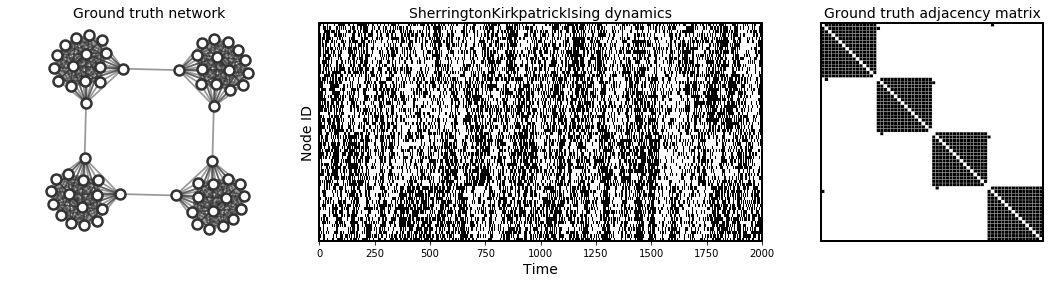

In [6]:
plot_groundtruth_timeseries_adjmat(G0,TS,dyna_name,save=False)

_________________

# 2.0: Introduction to the network reconstruction methods used in `netrd`

Note: these are not all of the reconstruction methods implemented in `netrd`, but they will be used in the following examples.

In [ ]:
recons = {
'ConvergentCrossMapping':       netrd.reconstruction.ConvergentCrossMapping(),
'CorrelationMatrix':            netrd.reconstruction.CorrelationMatrix(),
'ExactMeanField':               netrd.reconstruction.MeanField(),
'FreeEnergyMinimization':       netrd.reconstruction.FreeEnergyMinimization(),
'GraphicalLasso':               netrd.reconstruction.GraphicalLasso(),
'MarchenkoPastur':              netrd.reconstruction.MarchenkoPastur(),
'MaximumLikelihoodEstimation':  netrd.reconstruction.MaximumLikelihoodEstimation(),
'MutualInformationMatrix':      netrd.reconstruction.MutualInformationMatrix(),
'NaiveMeanField':               netrd.reconstruction.MeanField(),
'OUInference':                  netrd.reconstruction.OUInference(),
'ThoulessAndersonPalmer':       netrd.reconstruction.ThoulessAndersonPalmer(),
'PartialCorrelationMatrix':     netrd.reconstruction.PartialCorrelationMatrix(),
'NaiveTransferEntropy':         netrd.reconstruction.NaiveTransferEntropy(), # expensive 
'RegularizedCorrelationMatrix': netrd.reconstruction.CorrelationMatrix()}

recon_names = list(recons.keys())

abbreviations = {
'ConvergentCrossMapping':       "rCCM",
'CorrelationMatrix':            "rCOR",
'ExactMeanField':               "rEMF",
'FreeEnergyMinimization':       "rFEM",
'GraphicalLasso':               "rGLA",
'MarchenkoPastur':              "rMAR",
'MaximumLikelihoodEstimation':  "rMLE",
'MutualInformationMatrix':      "rMUT",
'NaiveMeanField':               "rNMF",
'OUInference':                  "rOUI",
'ThoulessAndersonPalmer':       "rTAP",
'PartialCorrelationMatrix':     "rPCM",
'PartialCorrelationInfluence':  "rPCI",
'NaiveTransferEntropy':         "rTRE", 
'RegularizedCorrelationMatrix': "rREG",
'GrangerCausality':             "rGRA",
'CorrelationSpanningTree':      "rMST",
'OptimalCausationEntropy':      "rOCE"}

## 2.1: One example reconstruction method: Free Energy Minimization

In [ ]:
recon_name = 'FreeEnergyMinimization'
colmap = plt.cm.Greys
plot_adjmat_timeseries_recon(G0, TS, recons, recon_name, colmap, save=True)

### 2.1.1: The `R1` object has a `R1.results` dictionary, which contains the following:

In [ ]:
R1 = recons[recon_name]
Gr = R1.fit(TS, threshold_type='degree', avg_k=k_avg)

print(R1.results.keys())

### 2.1.2: We often use the `netrd.utilities.threshold` when comparing reconstructions
Below are some options for how to threshold the reconstruction (the default in this notebook will be to threshold by the average degree of the ground truth network. **Note:** we rarely have enough information to ever justify this, but for explanatory purposes it is useful.)

In [ ]:
recon_name = 'FreeEnergyMinimization'
colmap = plt.cm.Greys
plot_different_thresholds_recons(G0, TS, recons, recon_name, colmap, save=True)

_________________

## 2.2: Now reconstruct _many_ time networks from the time series above (takes ~6min)

In [ ]:
k_avg = np.mean(list(dict(G0.degree()).values()))
Wlist = reconstruct_networks(TS, recons, recon_names, threshold_type='degree', avg_k=k_avg)

In [ ]:
colmap = plt.cm.Greys
plot_width = 5
plot_all_reconstructions(G0, Wlist, recons, recon_names, plot_width, colmap, save=True)

_________________

# 3.0: Introduction to the graph distances in `netrd`

Note: these are not all of the distances implemented in `netrd`, but they will be used in the following examples.

In [ ]:
dists = {
"JaccardDistance":         netrd.distance.JaccardDistance(), 
"Hamming":                 netrd.distance.Hamming(), 
"HammingIpsenMikhailov":   netrd.distance.HammingIpsenMikhailov(), 
"Frobenius":               netrd.distance.Frobenius(), 
"PolynomialDissimilarity": netrd.distance.PolynomialDissimilarity(), 
"PortraitDivergence":      netrd.distance.PortraitDivergence(), 
"OnionDivergence":         netrd.distance.OnionDivergence(), 
"QuantumSpectralJSD":      netrd.distance.QuantumJSD(), 
"DegreeDivergence":        netrd.distance.DegreeDivergence(), 
"ResistancePerturbation":  netrd.distance.ResistancePerturbation(), 
"NetLSD":                  netrd.distance.NetLSD(), 
"CommunicabilitySequence": netrd.distance.CommunicabilityJSD(),
"IpsenMikhailov":          netrd.distance.IpsenMikhailov(), 
"NonBacktrackingSpectral": netrd.distance.NonBacktrackingSpectral(), 
"NetSimile":               netrd.distance.NetSimile(), 
"DeltaCon":                netrd.distance.DeltaCon()}

dist_names = list(dists.keys())

## 3.1: Example case: measure (many) graph distance(s) between two BA networks

In [ ]:
n = 100
m = 2
G1 = nx.barabasi_albert_graph(n,m)
G2 = nx.barabasi_albert_graph(n,m)
print("Two BA networks with n=%i and m=%i are the following distances apart:\n"%(n,m))

example_G1G2_alldistances(G1, G2, dists, save=True)

## 3.2: Let's look at the distances between the reconstructions under one distance measure...

### ...but first: an introduction to the we often `standardize` function for distances in netrd

It is difficult to meaningully compare *across* distances, which is why we have introduced the standardized distance here. This means that the standardized distance (under distance, $d$) between $G_1$ and $G_2$ is expressed as follows:

$$D_s(G_1,G_2)_d = \dfrac{D(G_1,G_2)_d}{\langle D(G_{(n,p)},G'_{(n,p)})_d\rangle}$$

This means: we divide by the expected **mean within-ensemble graph distance** between pairs of graph randomly sampled from $G(n,p)$, where $n$ and $p$ correspond to the density and size of the graph in question. 

The command to standardize distances is below as `standardize.mean_GNP_distance(N, p, distance_measure)`.

## 3.3: One example distance to focus on: the quantum spectral Jensen-Shannon divergence

In [ ]:
dist_name='QuantumSpectralJSD'
dmat = specific_distance_all_reconstructions(G0, Wlist, dists, dist_name, stdrdze=True)

In [ ]:
order  = True
colmap = plt.cm.Greys
save   = True
plot_specific_distance_all_reconstructions(dmat, recons, recon_names, abbreviations, 
                                           dist_name, order, colmap, save)

## 3.4: Now, let's calculate all of the distances between all of the reconstructions (~2min)

In [ ]:
dmatlist = all_distances_all_reconstructions(G0, Wlist, dists, stdrdze=True)

### 3.4.1: Plotting with a common sorting of the distance matrices

In [ ]:
width = 4
single_order = True
colmap = plt.cm.Greys
save = True
plot_all_distances_all_reconstructions(dmatlist, recons, recon_names, abbreviations, 
                                       width, single_order, colmap, save)

### 3.4.2: Plotting without common sorting of the distance matrices

In [ ]:
width = 4
single_order = False
colmap = plt.cm.Greys
save = True
plot_all_distances_all_reconstructions(dmatlist, recons, recon_names, abbreviations, 
                                       width, single_order, colmap, save)

The ultimate goal is to develop a systematic understanding of network reconstruction techniques and graph distance measures using plots like the ones above. They correspond to techniques that are likely to generate *close* networks, and from that we will develop a better understanding about which methods to use.

# End of this `netrd` introduction. 

### Resources:
- __[Visit the github](https://github.com/netsiphd/netrd)__
- __[Visit the ReadTheDocs](https://netrd.readthedocs.io/en/latest/)__
- __[Visit the netrdExplorer website](https://netrdexplorer.herokuapp.com/)__